In [1]:
# Import libraries
import sys

import networkx as nx
import pandas as pd
import numpy as np
import os

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph.mapper import GraphSAGENodeGenerator, FullBatchNodeGenerator
from stellargraph.layer import GraphSAGE, GCN

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import json

In [2]:
# Setup GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


## Load Data and Preprocessing

In [2]:
# Import dataset
G = nx.read_graphml( "data/pubmed-diabetes/pubmed-diabetes.graphml" )

print(G) # should print a graph with 19717 nodes and 44338 edges

DiGraph with 19717 nodes and 44338 edges


In [4]:
G.graph

{'node_default': {}, 'edge_default': {}}

In [19]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) )

[
    "19127292",
    {
        "w-rat": 0.0,
        "w-common": 0.0,
        "w-use": 0.0,
        "w-examin": 0.02889892370027422,
        "w-pathogenesi": 0.0,
        "w-retinopathi": 0.0,
        "w-mous": 0.0,
        "w-studi": 0.03927472173927795,
        "w-anim": 0.0,
        "w-model": 0.0,
        "w-metabol": 0.0,
        "w-abnorm": 0.0,
        "w-contribut": 0.0,
        "w-develop": 0.0,
        "w-investig": 0.0,
        "w-mice": 0.0,
        "w-2": 0.0051138308462225415,
        "w-month": 0.0,
        "w-compar": 0.017653254069202904,
        "w-obtain": 0.0,
        "w-method": 0.0,
        "w-induc": 0.0,
        "w-6": 0.0,
        "w-inject": 0.0,
        "w-experiment": 0.0,
        "w-normal": 0.0,
        "w-diet": 0.0,
        "w-30": 0.0,
        "w-hyperglycemia": 0.0,
        "w-level": 0.0,
        "w-lipid": 0.0,
        "w-oxid": 0.0,
        "w-activ": 0.0,
        "w-protein": 0.0,
        "w-kinas": 0.0,
        "w-c": 0.0,
        "w-measur": 0.0

In [ ]:
# "label" := target variable, to be predicted
# "w-xxx" := word features, to be encoded as node features

In [3]:
# for each node, encode weight as a feature
for node in G.nodes():
    enc = [ val for key, val in G.nodes[node].items() if key != 'label' ]
    G.nodes[node]['feature'] = enc

In [29]:
for node in G.nodes( data=True ):
    print( node )
    break

('19127292', {'w-rat': 0.0, 'w-common': 0.0, 'w-use': 0.0, 'w-examin': 0.02889892370027422, 'w-pathogenesi': 0.0, 'w-retinopathi': 0.0, 'w-mous': 0.0, 'w-studi': 0.03927472173927795, 'w-anim': 0.0, 'w-model': 0.0, 'w-metabol': 0.0, 'w-abnorm': 0.0, 'w-contribut': 0.0, 'w-develop': 0.0, 'w-investig': 0.0, 'w-mice': 0.0, 'w-2': 0.0051138308462225415, 'w-month': 0.0, 'w-compar': 0.017653254069202904, 'w-obtain': 0.0, 'w-method': 0.0, 'w-induc': 0.0, 'w-6': 0.0, 'w-inject': 0.0, 'w-experiment': 0.0, 'w-normal': 0.0, 'w-diet': 0.0, 'w-30': 0.0, 'w-hyperglycemia': 0.0, 'w-level': 0.0, 'w-lipid': 0.0, 'w-oxid': 0.0, 'w-activ': 0.0, 'w-protein': 0.0, 'w-kinas': 0.0, 'w-c': 0.0, 'w-measur': 0.011734827227009909, 'w-result': 0.005626481865792995, 'w-increas': 0.013080628861391524, 'w-retin': 0.0, 'w-stress': 0.0, 'w-3': 0.009410652924576506, 'w-similar': 0.0, 'w-observ': 0.013638082547296626, 'w-conclus': 0.009595651021257695, 'w-play': 0.0, 'w-import': 0.0, 'w-role': 0.0, 'w-present': 0.0, 'w-p

In [4]:
# copy graph
from copy import deepcopy
G2 = deepcopy(G)

# remove redundant weight attributes from nodes
for node in G2.nodes():
    for key in G2.nodes[node].keys():
        if key != 'label' and key != 'feature':
            G.nodes[node].pop(key)

del G2

In [23]:
# print updated node attributes
for node in G.nodes( data=True ):
    print( node )
    break

('19127292', {'label': 3, 'feature': [0.0, 0.0, 0.0, 0.02889892370027422, 0.0, 0.0, 0.0, 0.03927472173927795, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0051138308462225415, 0.0, 0.017653254069202904, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011734827227009909, 0.005626481865792995, 0.013080628861391524, 0.0, 0.0, 0.009410652924576506, 0.0, 0.013638082547296626, 0.009595651021257695, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013707596952315111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018018854082796857, 0.0, 0.0, 0.026654784576510108, 0.0, 0.018187833938568296, 0.021453823869012026, 0.0, 0.0, 0.0, 0.015206016428791635, 0.02445769293081941, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01464439249807633, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01392805234916936, 0.0, 0.046675881510411174, 0.01851450237325145, 0.0, 0.0, 0.0, 0.013858803228687022, 0.0, 0.016871029143029966, 0

In [31]:
print( json.dumps( list( G.nodes(data=True) )[0], indent = 4 ) )

[
    "19127292",
    {
        "label": 3,
        "feature": [
            0.0,
            0.0,
            0.0,
            0.02889892370027422,
            0.0,
            0.0,
            0.0,
            0.03927472173927795,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0051138308462225415,
            0.0,
            0.017653254069202904,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.011734827227009909,
            0.005626481865792995,
            0.013080628861391524,
            0.0,
            0.0,
            0.009410652924576506,
            0.0,
            0.013638082547296626,
            0.009595651021257695,
 

In [11]:
print( json.dumps( list( G.edges(data=True) )[0], indent = 4 ) )

[
    "19127292",
    "17363749",
    {
        "id": "0"
    }
]


## Create StellarGraph

In [5]:
# Since G is a multi-graph, we need to convert it to an homogeneous graph

# rename "label" to "target"
for node in G.nodes():
    G.nodes[node]['target'] = G.nodes[node]['label']
    G.nodes[node].pop('label')

In [6]:
# print updated node attributes
for node in G.nodes( data=True ):
    print( node )
    break

('19127292', {'feature': [0.0, 0.0, 0.0, 0.02889892370027422, 0.0, 0.0, 0.0, 0.03927472173927795, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0051138308462225415, 0.0, 0.017653254069202904, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.011734827227009909, 0.005626481865792995, 0.013080628861391524, 0.0, 0.0, 0.009410652924576506, 0.0, 0.013638082547296626, 0.009595651021257695, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.013707596952315111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.018018854082796857, 0.0, 0.0, 0.026654784576510108, 0.0, 0.018187833938568296, 0.021453823869012026, 0.0, 0.0, 0.0, 0.015206016428791635, 0.02445769293081941, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01464439249807633, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01392805234916936, 0.0, 0.046675881510411174, 0.01851450237325145, 0.0, 0.0, 0.0, 0.013858803228687022, 0.0, 0.016871029143029966, 0.01879045174

In [7]:
SG = StellarGraph.from_networkx(
    graph=G, node_features="feature", node_type_default="paper"
)

print( SG.info() )

StellarDiGraph: Directed multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-default->paper

 Edge types:
    paper-default->paper: [44338]
        Weights: all 1 (default)
        Features: none


In [8]:
# create a node_subjects Pandas Series with node IDs as index and subject as value
node_subjects = pd.Series( [ G.nodes[node]['target'] for node in G.nodes() ], index = G.nodes() )
print( node_subjects.head() )

19127292    3
17363749    3
19668377    3
17293876    3
1313726     1
dtype: int64


In [14]:
# split into train and test sets
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects
)

test_subjects, val_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

print( train_subjects )

7664638     3
18504548    3
11472273    2
10791012    3
10588367    1
           ..
6224805     2
8990188     2
1468289     2
9703314     2
17064208    2
Length: 13801, dtype: int64


In [10]:
from collections import Counter
Counter(train_subjects) # consider imbalance between class

Counter({1: 410, 2: 787, 3: 774})

In [15]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
test_targets = le.transform(test_subjects)
val_targets = le.transform(val_subjects)

In [12]:
print( train_targets ) # for each node, the subject is encoded as a number

[[1 0 0]
 [0 1 0]
 [0 1 0]
 ...
 [0 1 0]
 [1 0 0]
 [0 0 1]]


## Define benchmarking metrics

In [16]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, accuracy_score, classification_report

# write a function to calculate benchmark metrics

def calculate_metrics(y_true, y_pred):

    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred)

    return precision, recall, f1, accuracy, cm, cr

## GraphSAGE model

In [17]:
batch_size = 50
num_samples = [10, 10]

generator = GraphSAGENodeGenerator( SG, batch_size, num_samples )

In [18]:
train_gen = generator.flow( train_subjects.index, train_targets, shuffle = True )

In [19]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5, activations=["relu", "relu"]
)

In [20]:
print( train_targets.shape )

(13801, 3)


In [21]:
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [22]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [23]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [24]:
# introduce early stopping
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)

In [25]:
history = model.fit(
    train_gen, epochs=10, validation_data=test_gen, verbose=2, shuffle=False
)

Epoch 1/10
277/277 - 26s - loss: 0.5435 - acc: 0.8031 - val_loss: 0.3979 - val_acc: 0.8509 - 26s/epoch - 93ms/step
Epoch 2/10
277/277 - 22s - loss: 0.4061 - acc: 0.8521 - val_loss: 0.3437 - val_acc: 0.8736 - 22s/epoch - 79ms/step
Epoch 3/10
277/277 - 22s - loss: 0.3771 - acc: 0.8585 - val_loss: 0.3264 - val_acc: 0.8729 - 22s/epoch - 79ms/step
Epoch 4/10
277/277 - 24s - loss: 0.3612 - acc: 0.8647 - val_loss: 0.3232 - val_acc: 0.8847 - 24s/epoch - 85ms/step
Epoch 5/10
277/277 - 23s - loss: 0.3561 - acc: 0.8683 - val_loss: 0.3238 - val_acc: 0.8796 - 23s/epoch - 81ms/step
Epoch 6/10
277/277 - 25s - loss: 0.3383 - acc: 0.8714 - val_loss: 0.3273 - val_acc: 0.8780 - 25s/epoch - 89ms/step
Epoch 7/10
277/277 - 23s - loss: 0.3351 - acc: 0.8746 - val_loss: 0.3099 - val_acc: 0.8908 - 23s/epoch - 82ms/step
Epoch 8/10
277/277 - 25s - loss: 0.3300 - acc: 0.8754 - val_loss: 0.3125 - val_acc: 0.8884 - 25s/epoch - 90ms/step
Epoch 9/10
277/277 - 28s - loss: 0.3213 - acc: 0.8769 - val_loss: 0.3137 - val_a

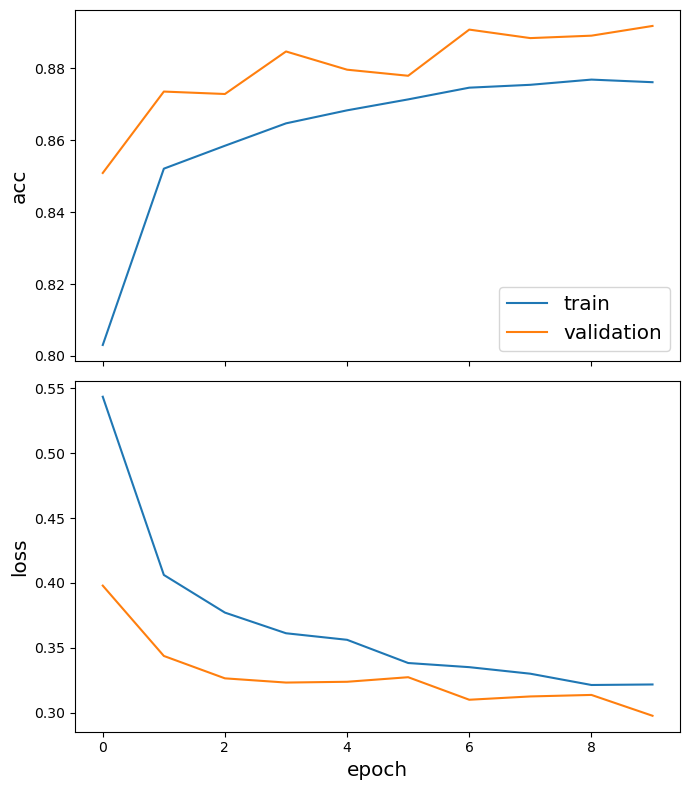

In [26]:
sg.utils.plot_history(history)

In [27]:
# unseen data (validation set)
val_gen = generator.flow(val_subjects.index, val_targets)

In [28]:
test_metrics = model.evaluate(val_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

60/60 [==============================] - 5s 80ms/step - loss: 0.3077 - acc: 0.8837

Test Set Metrics:
	loss: 0.3077
	acc: 0.8837


### Benchmark model

In [29]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

395/395 [==============================] - 31s 77ms/step


In [30]:
node_predictions = le.inverse_transform(all_predictions)

In [31]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

,Predicted,True
19127292,3,3
17363749,3,3
19668377,3,3
17293876,3,3
1313726,1,1
3002783,1,1
19110882,3,3
14578298,2,2
18606979,2,2
10333910,2,2


In [32]:
# Calculate benchmark metrics

precision, recall, f1, accuracy, cm, cr = calculate_metrics(df['True'], df['Predicted'])

print( "Precision: ", precision )
print( "Recall: ", recall )
print( "F1: ", f1 )
print( "Accuracy: ", accuracy )
print( "Confusion Matrix:\n ", cm )
print( "Classification Report: ", cr )


Precision:  0.9024699497895218
Recall:  0.9024699497895218
F1:  0.9024699497895218
Accuracy:  0.9024699497895218
Confusion Matrix:
  [[3522  337  244]
 [ 213 6957  705]
 [  95  329 7315]]
Classification Report:                precision    recall  f1-score   support

           1       0.92      0.86      0.89      4103
           2       0.91      0.88      0.90      7875
           3       0.89      0.95      0.91      7739

    accuracy                           0.90     19717
   macro avg       0.91      0.90      0.90     19717
weighted avg       0.90      0.90      0.90     19717



## GCN model

In [33]:
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects
)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

In [34]:
train_subjects.value_counts().to_frame() # why is equal to demo?

,0
2,5512
3,5417
1,2872


In [35]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [36]:
generator = FullBatchNodeGenerator(SG, method="gcn")

Using GCN (local pooling) filters...


In [37]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [38]:
gcn = GCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [39]:
x_inp, x_out = gcn.in_out_tensors()

In [40]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Train model

In [41]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [42]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [44]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 2s - loss: 1.0952 - acc: 0.4337 - val_loss: 1.0820 - val_acc: 0.4730 - 2s/epoch - 2s/step
Epoch 2/200
1/1 - 0s - loss: 1.0822 - acc: 0.4601 - val_loss: 1.0660 - val_acc: 0.4804 - 475ms/epoch - 475ms/step
Epoch 3/200
1/1 - 0s - loss: 1.0671 - acc: 0.4746 - val_loss: 1.0491 - val_acc: 0.5041 - 402ms/epoch - 402ms/step
Epoch 4/200
1/1 - 0s - loss: 1.0513 - acc: 0.4974 - val_loss: 1.0322 - val_acc: 0.5250 - 328ms/epoch - 328ms/step
Epoch 5/200
1/1 - 0s - loss: 1.0338 - acc: 0.5208 - val_loss: 1.0153 - val_acc: 0.5500 - 333ms/epoch - 333ms/step
Epoch 6/200
1/1 - 0s - loss: 1.0184 - acc: 0.5441 - val_loss: 0.9988 - val_acc: 0.5740 - 449ms/epoch - 449ms/step
Epoch 7/200
1/1 - 0s - loss: 1.0042 - acc: 0.5634 - val_loss: 0.9824 - val_acc: 0.6038 - 354ms/epoch - 354ms/step
Epoch 8/200
1/1 - 1s - loss: 0.9869 - acc: 0.5821 - val_loss: 0.9653 - val_acc: 0.6362 - 508ms/epoch - 508ms/step
Epoch 9/200
1/1 - 0s - loss: 0.9716 - acc: 0.5997 - val_loss: 0.9466 - val_acc: 0.6481 - 324ms

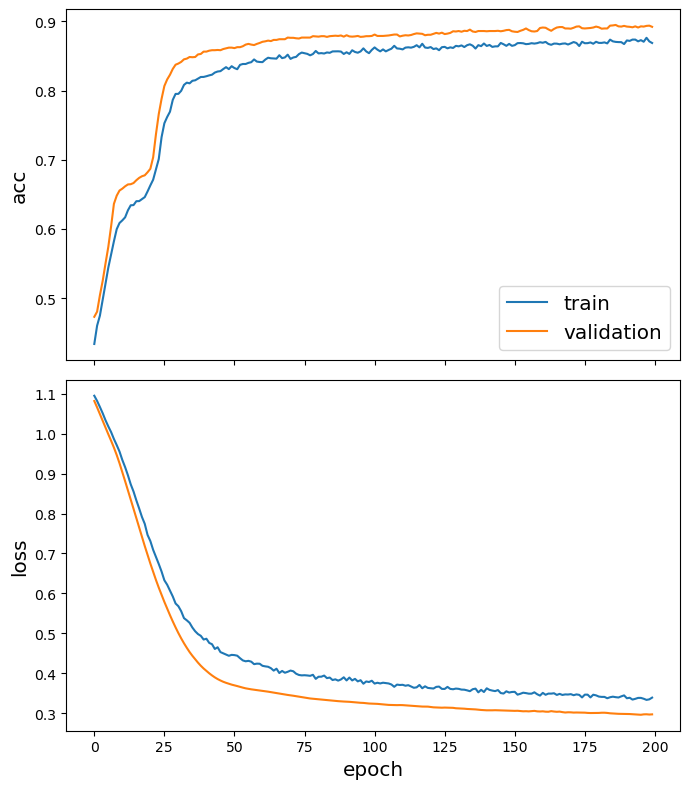

In [45]:
sg.utils.plot_history(history)

In [46]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [47]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 125ms/step - loss: 0.3095 - acc: 0.8800

Test Set Metrics:
	loss: 0.3095
	acc: 0.8800


### Benchmark model

In [48]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

1/1 [==============================] - 0s 281ms/step


In [49]:
node_predictions = le.inverse_transform(all_predictions.squeeze())

In [50]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

,Predicted,True
19127292,3,3
17363749,3,3
19668377,3,3
17293876,3,3
1313726,1,1
3002783,1,1
19110882,3,3
14578298,2,2
18606979,2,2
10333910,2,2


In [51]:
# Calculate benchmark metrics

precision, recall, f1, accuracy, cm, cr = calculate_metrics(df['True'], df['Predicted'])

print( "Precision: ", precision )
print( "Recall: ", recall )
print( "F1: ", f1 )
print( "Accuracy: ", accuracy )
print( "Confusion Matrix:\n ", cm )
print( "Classification Report: ", cr )


Precision:  0.8920728305523152
Recall:  0.8920728305523152
F1:  0.8920728305523152
Accuracy:  0.8920728305523152
Confusion Matrix:
  [[3634  308  161]
 [ 378 6878  619]
 [ 249  413 7077]]
Classification Report:                precision    recall  f1-score   support

           1       0.85      0.89      0.87      4103
           2       0.91      0.87      0.89      7875
           3       0.90      0.91      0.91      7739

    accuracy                           0.89     19717
   macro avg       0.89      0.89      0.89     19717
weighted avg       0.89      0.89      0.89     19717



## GAT model

In [52]:
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

In [53]:
# split data
train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=0.7, test_size=None, stratify=node_subjects
)

val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=0.5, test_size=None, stratify=test_subjects
)

In [54]:
from collections import Counter

Counter(train_subjects)

Counter({2: 5512, 1: 2872, 3: 5417})

In [55]:
# Convert to numeric labels
le = preprocessing.LabelBinarizer()
train_targets = le.fit_transform(train_subjects)
val_targets = le.transform(val_subjects)
test_targets = le.transform(test_subjects)

In [56]:
# Create the GAT model
generator = FullBatchNodeGenerator(SG, method="gat")

In [57]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [58]:
gat = GAT(
    layer_sizes=[32, 32],
    activations=["relu", "relu"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [59]:
x_inp, x_out = gat.in_out_tensors()

In [60]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [61]:
model = Model(inputs=x_inp, outputs= predictions)
model.compile(
    optimizer=optimizers.Adam( learning_rate=0.005 ),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [62]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [63]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [64]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/200
1/1 - 6s - loss: 1.0933 - acc: 0.3795 - val_loss: 1.0650 - val_acc: 0.5527 - 6s/epoch - 6s/step
Epoch 2/200
1/1 - 1s - loss: 1.0667 - acc: 0.4528 - val_loss: 1.0316 - val_acc: 0.5808 - 1s/epoch - 1s/step
Epoch 3/200
1/1 - 1s - loss: 1.0406 - acc: 0.4765 - val_loss: 0.9977 - val_acc: 0.5852 - 1s/epoch - 1s/step
Epoch 4/200
1/1 - 1s - loss: 1.0141 - acc: 0.5044 - val_loss: 0.9654 - val_acc: 0.6041 - 944ms/epoch - 944ms/step
Epoch 5/200
1/1 - 1s - loss: 0.9906 - acc: 0.5189 - val_loss: 0.9309 - val_acc: 0.6275 - 1s/epoch - 1s/step
Epoch 6/200
1/1 - 1s - loss: 0.9695 - acc: 0.5276 - val_loss: 0.8909 - val_acc: 0.6406 - 999ms/epoch - 999ms/step
Epoch 7/200
1/1 - 1s - loss: 0.9335 - acc: 0.5421 - val_loss: 0.8495 - val_acc: 0.6433 - 1s/epoch - 1s/step
Epoch 8/200
1/1 - 1s - loss: 0.9020 - acc: 0.5529 - val_loss: 0.8108 - val_acc: 0.6738 - 1s/epoch - 1s/step
Epoch 9/200
1/1 - 1s - loss: 0.8683 - acc: 0.5850 - val_loss: 0.7727 - val_acc: 0.7563 - 1s/epoch - 1s/step
Epoch 10/200
1/1

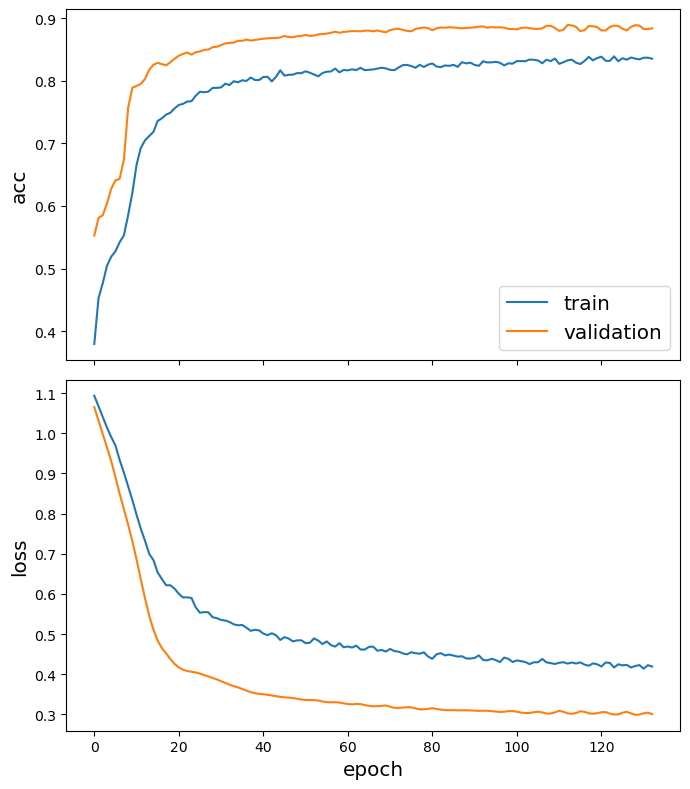

In [65]:
sg.utils.plot_history(history)

In [66]:
model.load_weights("logs/best_model.h5")

In [67]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [68]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 230ms/step - loss: 0.3224 - acc: 0.8759

Test Set Metrics:
	loss: 0.3224
	acc: 0.8759


### Benchmark model

In [70]:
all_nodes = node_subjects.index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

1/1 [==============================] - 2s 2s/step


In [71]:
node_predictions = le.inverse_transform(all_predictions.squeeze())

In [72]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(10)

,Predicted,True
19127292,3,3
17363749,3,3
19668377,3,3
17293876,3,3
1313726,1,1
3002783,1,1
19110882,3,3
14578298,2,2
18606979,2,2
10333910,2,2


In [73]:
# Calculate benchmark metrics

precision, recall, f1, accuracy, cm, cr = calculate_metrics(df['True'], df['Predicted'])

print( "Precision: ", precision )
print( "Recall: ", recall )
print( "F1: ", f1 )
print( "Accuracy: ", accuracy )
print( "Confusion Matrix:\n ", cm )
print( "Classification Report: ", cr )


Precision:  0.8928843130293656
Recall:  0.8928843130293656
F1:  0.8928843130293656
Accuracy:  0.8928843130293656
Confusion Matrix:
  [[3681  273  149]
 [ 330 6682  863]
 [ 229  268 7242]]
Classification Report:                precision    recall  f1-score   support

           1       0.87      0.90      0.88      4103
           2       0.93      0.85      0.89      7875
           3       0.88      0.94      0.91      7739

    accuracy                           0.89     19717
   macro avg       0.89      0.89      0.89     19717
weighted avg       0.89      0.89      0.89     19717

